In [46]:
from scipy.ndimage.morphology import binary_hit_or_miss
from commonfunctions import *
import numpy as np
import os
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect
import scipy.stats
from skimage import draw
from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin,
                               opening
                              )
from skimage.measure import find_contours
from skimage.filters import rank
from skimage.draw import rectangle
from skimage.filters import threshold_otsu, gaussian
from skimage import feature


In [2]:
import cv2
if ' ':
    print('hi')
    
def cv_show(image):
    image=np.uint8(image)
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

hi


In [3]:
# omar do those
def which_number(num_image):
    """
    returns: zero is image wasn't a number
    or returns the number that it represents either
    1, 2, 3, 4, ...., 9
    
    arguments:
    num_image: this is an image of small size
    """
    pass

def which_symbol_division(sym_image):
    """
    returns which duration eg, if a/4 return 4, if a/8 return 8, if a/16, a/32 
    if not any one return 0
    
    arguments:
    sym_image: this is an image of small size
    """
    pass



In [4]:
# atia do this


def number_of_beams(sym_image):
    """
    returns the number of beams that are found in beaming symbols    
    arguments:
    sym_image: this is an image of small size
    """
    pass

def filled_holes_centers(char, radius):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size where the filled_ovals
    """
    padded_char = padd_image(char)    
    erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
    b_boxes = get_external_bounding_boxes(erroded_image)
    centers = []
    for box in b_boxes:
        X,Y,w,h = box
        cx = X+w//2
        cy=Y+h//2
        centers.append((cx,cy))

    return centers

def which_accidentals(sym_image):
    """
    returns: accidental is found in that image
    returns '#' if # or '&' if b or ' '(space) if neutral '##' if X '&&' if bb
    or return ''(empty) or None if not any of these
    arguments:
    sym_image: this is an image of small size
    """
    pass

In [5]:
# classes
class staff_meta(object):
    division_height = -1
    line_thickness = -1
    staff_lines_y_coords = []
notes_pitch = [
    'e',    # bottom line (or the 5th from above)
    'f',
    'g',
    'a',
    'b',
    'c',
    'd'
]


In [93]:
def read_Image(imgLocation):
    original_image = io.imread(imgLocation)
    if len(original_image.shape) != 2:
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = original_image
    binary_image = binarize(gray_image)
    return binary_image

####################################
# Data Set
sift = cv2.xfeatures2d.SIFT_create()


DataSets_Path = ['images/dataset0','images/dataset1']
List_Path = []

for path in DataSets_Path:
    List_Path.append(os.listdir(path))

DataSet0 = []
for imgLocation in List_Path[0]:
    img = cv2.imread( f'{DataSets_Path[0]}/{imgLocation}', 0)
    kp , des = sift.detectAndCompute( img , None )
    DataSet0.append( [img, os.path.splitext(imgLocation)[0],des] )
    print( imgLocation , len(des) )
print()
DataSet1 = []
for imgLocation in List_Path[1]:
    img = cv2.imread( f'{DataSets_Path[1]}/{imgLocation}', 0)
    kp , des = sift.detectAndCompute( img , None )
    DataSet1.append( [img, os.path.splitext(imgLocation)[0],des] )
    print( imgLocation , len(des) )


6.jpg 27
Half-Note2.png 46
Half-Note1.png 46
3.jpg 32
G-Clef-Note.png 61
Half-Note3.png 42
1.jpg 7
8.jpg 19
2.jpg 17
Whole-Note.png 18
5.jpg 34
9.jpg 38
4.jpg 18
7.jpg 16

8th-Note2.png 36
8th-Note4.png 41
8th-Note1.png 53
8th-Note3.png 48
Quarter-Note1.png 45


In [77]:
# Matching
bf = cv2.BFMatcher()

def Matcher( char , n ):
    DataSet = []
    if n == 0:
        DataSet = DataSet0
    elif n == 1:
        DataSet = DataSet1
    
    kp , des = sift.detectAndCompute(char,None)
    
    MatchLengthes = []
    
    maxGoodMatches = 0
    classifiedName = ""
    
    if len(kp) > 0:
        matchlengthes = []
        for s in DataSet:
            matches = bf.knnMatch(s[2],des,k=2)
            #matches = bf.knnMatch(des,s[2],k=2)
            
            good = [[m] for m, n in matches if m.distance < 0.635*n.distance]
            if len(good) > maxGoodMatches:
                maxGoodMatches = len(good)
                classifiedName = s[1]
            matchlengthes.append(len(good))
        if maxGoodMatches > 2:
            return [classifiedName,matchlengthes]
    return 0

In [10]:
def get_trace_meta(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image        
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    division_height=0
    h_max = 1
    bounding_rects = []
    for c in cnts:
        bounding_rects.append(cv2.boundingRect(c))

    for b_rect in bounding_rects:
        X,Y,w,h = b_rect
        if h > h_max:
            h_max = h
    def contour_y(c):
        return c[1]
    bounding_rects = sorted(bounding_rects, key=contour_y)
    lines_y_coordinates = [ b[1] for b in bounding_rects]
    div_height = bounding_rects[1][1] - bounding_rects[0][1]
    s_meta = staff_meta()
    s_meta.division_height = div_height
    s_meta.line_thickness = h_max
    s_meta.staff_lines_y_coords = lines_y_coordinates
    return s_meta

In [11]:
def padd_image(img):
    """
    this functions padds an image this is very important 
    when applying erosion as applying erosion to border 
    may result false postives
    """
    out_img = np.zeros((img.shape[0]+2,img.shape[1]+2), dtype=np.uint8)
    out_img[1:out_img.shape[0]-1,1:out_img.shape[1]-1] = img
    return out_img

In [12]:
def conv_255_true(image):
    image[image == 255] = True
    image[image == 0] = False
    return image
def remove_horizontal_wrapper(org_image, inv_image):
    # both org_image and inv_image must uint8 
    line_width, no_staf_1 = remove_horizontal_lines(org_image)
    no_staf_1 = conv_255_true(no_staf_1)
    no_staf = no_staf_1
    inv_image = conv_255_true(inv_image)
    no_staf = np.bitwise_and(no_staf, inv_image)
    return no_staf
def remove_horizontal_lines(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max=h
    for c in cnts:   
#         print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
#         cv2.imshow('result', gray)
#         cv2.waitKey()
#     cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
#     print("repair", repair_kernel)
    result = 255-cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
#     cv2.imshow('result', gray)
#     cv2.waitKey()
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return h_max,result

In [13]:
def get_external_bounding_boxes(img):
    """
    this function takes and image and returns an array
    of bounding rectangle [(X1,Y1,W1,H1),(X2,Y2,W2,H2),....]
    where 
    Wi: is the width
    Hi: is the height
    """
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bounding_rects = []
    for c in cnts:
        b_r = cv2.boundingRect(c)
        # X,Y,w,h = b_r
        bounding_rects.append(b_r)    # 
    def contour_x(c):
        return c[0]
    bounding_rects = sorted(bounding_rects, key=contour_x)
    return bounding_rects
def draw_external_bounding_boxes(img,b_rects):
    out = img.copy()
    for b_r in b_rects:
        X,Y,w,h = b_r
        out = cv2.rectangle(out, (X,Y), (X+w, Y+h),1,3)
    return out

In [14]:
# common functions
def binary_opening(img, selem):
    return binary_dilation(binary_erosion(img, selem=selem), selem=selem)

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns the bounding boxes sorted according to x-min
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8, fully_connected="low")
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        if(Ymax-Ymin != 0):
            aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        else:
            aspect_ratio = 3000
            
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
    
    
    def x_min(shape):
        return shape[0]             

    bounding_boxes = sorted(bounding_boxes, key=x_min)
    return bounding_boxes
#     no_duplicated_boxes=[bounding_boxes[0]]
#     for i in range(1, len(bounding_boxes)):
#         pre_box=bounding_boxes[i-1]
#         curr_box = bounding_boxes[i]
#         if curr_box[0] >= pre_box[0] and curr_box[1] <= pre_box[1] and curr_box[2] >= pre_box[2] and curr_box[3]<= pre_box[3]:
#             continue
#         else:
#             no_duplicated_boxes.append(curr_box)
#         print(pre_box," --- " ,curr_box)
#     return no_duplicated_boxes


def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


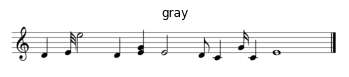

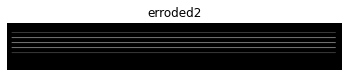

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


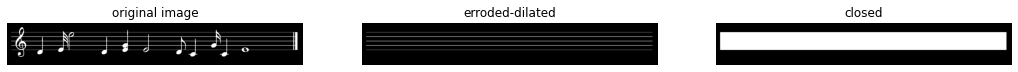

11648


In [15]:
# images_paths = ['images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
# images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
images_paths = [ f"test-cases/0{i+1}.PNG" for i in range(9)]

original_image = io.imread(images_paths[0])
gray_image = rgb2gray(original_image)
show_images([gray_image], ['gray'])
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image

inverted_image[:, inverted_image.shape[1]-1]=0
rows=1
cols=original_image.shape[1] // 4
selem = rect(rows,cols)
erroded_img = binary_erosion(inverted_image,selem=selem)

rows=1
cols=original_image.shape[1] // 4
selem = rect(rows,cols)
erroded_img2 = binary_dilation(erroded_img, selem=selem)
# inverted_image2 = inverted_image - erroded_img2

show_images([erroded_img2], ['erroded2'])
print(erroded_img)
rows = original_image.shape[0] // 8
cols = 1
selem = rect(rows,cols)
closed_img  = binary_closing(erroded_img2, selem = selem)


# closed_img  = binary_closing(closed_img, selem = selem)
show_images([inverted_image,erroded_img2,closed_img],['original image','erroded-dilated','closed'])

staffs_area = np.sum(erroded_img2)
print(staffs_area)

In [84]:
#  calculate the trace bounding boxes
trace_bounding_boxes = get_bounding_boxes(closed_img,(1,4000))
# print(trace_bounding_boxes)
bigger_trace_bounding_boxes = []
trace_images_array = []
division_height=0
trace_height = 0
for box in trace_bounding_boxes:
    trace_height = box[3]-box[2]
    trace_width = box[1] - box[0]
    division_height = (trace_height)/4
    division_height = int(np.ceil(division_height)) 
#     division_height *=2
    [Xmin, Xmax, Ymin, Ymax] = [int(round(x)) for x in box]
    Ymin -= 2 * division_height
    Ymin = Ymin if Ymin >0 else 0
    Ymax += 2 * division_height
    bigger_trace_bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    trace_images_array.append(gray_image[Ymin:Ymax,Xmin:Xmax])
staff_length = bigger_trace_bounding_boxes

# print(staffs_area, trace_width)

# print(staffs_area // (len(bigger_trace_bounding_boxes) * 5 *trace_width ))

# print(bigger_trace_bounding_boxes)
# print(inverted_image.shape)

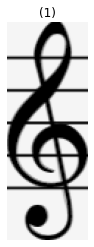

width: 55, height: 149, division_height: 22
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
['G-Clef-Note', [0, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0]]



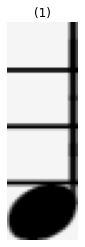

width: 28, height: 86, division_height: 22
oval_centers  [(14, 77)]
this maybe a quarter or 8th or 16th or 32th or a clef
['Quarter-Note1', [6, 0, 7, 2, 9]]



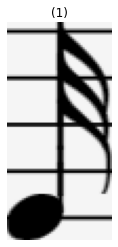

width: 50, height: 104, division_height: 22
oval_centers  [(14, 94)]
this maybe a quarter or 8th or 16th or 32th or a clef
['8th-Note1', [0, 0, 6, 3, 3]]



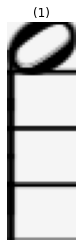

width: 27, height: 86, division_height: 22
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
['Half-Note2', [0, 8, 7, 0, 0, 8, 0, 1, 0, 0, 0, 0, 0, 0]]



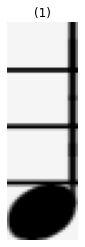

width: 28, height: 86, division_height: 22
oval_centers  [(14, 77)]
this maybe a quarter or 8th or 16th or 32th or a clef
0



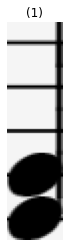

width: 28, height: 110, division_height: 22
oval_centers  [(14, 100), (15, 78)]
this is a chord



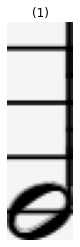

width: 27, height: 89, division_height: 22
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
['Half-Note3', [0, 3, 4, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0]]



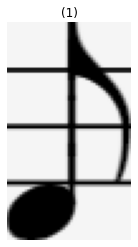

width: 49, height: 86, division_height: 22
oval_centers  [(14, 77)]
this maybe a quarter or 8th or 16th or 32th or a clef
['Quarter-Note1', [4, 0, 2, 2, 6]]



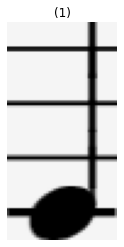

width: 45, height: 89, division_height: 22
oval_centers  [(24, 79)]
this maybe a quarter or 8th or 16th or 32th or a clef
['Quarter-Note1', [3, 1, 4, 2, 11]]



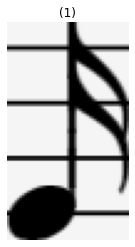

width: 49, height: 88, division_height: 22
oval_centers  [(15, 78)]
this maybe a quarter or 8th or 16th or 32th or a clef
['8th-Note1', [10, 2, 11, 3, 9]]



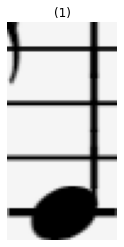

width: 45, height: 89, division_height: 22
oval_centers  [(24, 79)]
this maybe a quarter or 8th or 16th or 32th or a clef
['8th-Note2', [4, 0, 4, 0, 0]]



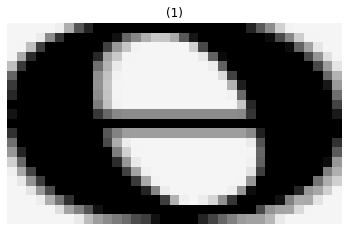

width: 35, height: 21, division_height: 22
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
0



width: 4, height: 86, division_height: 22
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
0



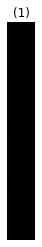

width: 11, height: 86, division_height: 22
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
0



In [94]:
# for each trace segment the individual characters
no_horizontal_staff_images = []
staff_images = []
gray_staff_images=[]
sh = lambda x: print ("shape is ",x.shape)
line_height = 3
for i, trace in enumerate(bigger_trace_bounding_boxes):
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    newOrigin = [Xmin,Ymin]
    
    #show_images([original_image[Ymin:Ymax,Xmin:Xmax]], ['ori'])
    no_staf=remove_horizontal_wrapper(original_image[Ymin:Ymax,Xmin:Xmax],inverted_image[Ymin:Ymax,Xmin:Xmax].astype(np.uint8) )
    no_horizontal_staff_images.append(no_staf)
    # show_images([no_staf], ['no_staf'])
    
    char_boxes = get_external_bounding_boxes(no_staf)
    out = draw_external_bounding_boxes(no_staf, char_boxes)
    #show_images([out,no_staf])
    #print(char_boxes)
    # io.imsave('test.jpg', no_staf*255)
    # break
    j=0
    chars = []
    org_chars = []
    trace_info: staff_meta = get_trace_meta(original_image[Ymin:Ymax,Xmin:Xmax])
    # print(trace_info.__dict__)
    
    for box in char_boxes:
        [Xmin, Ymin, W, H] = [x for x in box]
        # remove blank or noisy area that is less than a line of pixels
        char = no_staf[Ymin:Ymin+H,Xmin:Xmin+W]
        org_char = original_image[Ymin+newOrigin[1]:Ymin+H+newOrigin[1],Xmin+newOrigin[0]:Xmin+W+newOrigin[0]]

        # reject noise before appending
        # 1. box area == 0
        if(np.sum(char) == 0):
            continue
        
        # print(filled_holes_centers(char,trace_info.division_height))
        
        radius = int(trace_info.division_height // 3 )
        # padded_char = padd_image(char)        
        # erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
        # b_boxes = get_external_bounding_boxes(erroded_image)
        
        oval_centers = filled_holes_centers(char, radius)
        
        show_images([org_char])
        print("width: {}, height: {}, division_height: {}".format(W,H,trace_info.division_height))
        print("oval_centers ",oval_centers)

        if W < trace_info.division_height//2 and H < trace_info.division_height//2:
            # use the properties of a dot or circle to know for sure it is a dot
            print("this may be a dot or noise")
        else:
            if len(oval_centers) == 0:
                # use sift to distinguish between them
                print("this is may be a clef, half, whole , a number or accidentals noise or beam")
                matcherout = Matcher(org_char , 0)
                print(matcherout)
                
            elif len(oval_centers) == 1:
                print("this maybe a quarter or 8th or 16th or 32th or a clef")
                matcherout = Matcher(org_char , 1)
                print(matcherout)
            elif len(oval_centers) >= 2:
                # print("this note is beamed or chords")
                # using the x difference between the 1st 2 centre we can separate between chords 
                # or beams
                if oval_centers[1][0] - oval_centers[0][0] > int(1.5*trace_info.division_height):
                    print("this is a beam")
                else:
                    print("this is a chord")

        
        chars.append(char)
        org_chars.append(org_char)
        print()
        # 
        j+=1
    # show_images([no_staf], ['no_staf rectangles'])
    staff_images.append(chars)


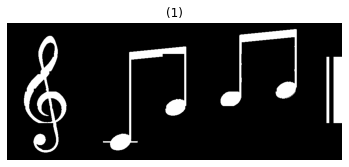

In [78]:
show_images([no_horizontal_staff_images[0]])

In [48]:
for staff_chars in staff_images:
    j=0
    j+=1
    for char in staff_chars:
        i=0
        i+=1
        # show_images([char],[f"char {j}-{i}"])
        
        
        
        

In [ ]:
# USING CONNNECTED COMPONENETS

ret, labels = cv2.connectedComponents(binary)
print("hi")

In [ ]:

from skimage import data
from skimage.viewer import ImageViewer

image = original_image
viewer = ImageViewer(image)
viewer.show()

In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))


image = cv2.imread('images/8th_Sheet1.jpeg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))

# thresh = cv2.Canny(thresh, 30, 200) 
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# print(cnts)
cont_areas = get_avg_contour_areas(cnts)
print("avg" , cont_areas)
for c in cnts:
    print(len(c))
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    print(cv2.boundingRect(c))
    cv2.imshow('result', image)
    cv2.waitKey()
cv2.destroyAllWindows()

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
print("repair", repair_kernel)
result = cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
kernel = np.ones((1,15),np.uint8)
# er = cv2.dilate(result,kernel,iterations = 1)


showHist(result)
cv2.imshow('thresh', thresh)
cv2.imshow('detected_lines', detected_lines)
cv2.imshow('image', image)
# cv2.imshow('er', er)
cv2.imshow('result', result)
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))
# images_paths = [ f"test-cases/0{i+1}.png" for i in range(9)]
images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
for image_path in images_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # print(cnts)
#     print("avg" , cont_areas)
    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max = h
       
    break   
    for c in cnts:   
#         print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
        cv2.imshow('result', gray)
        cv2.waitKey()
    cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
#     print("repair", repair_kernel)
    result = cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    showHist(result)
    cv2.imshow('thresh', thresh)
    cv2.imshow('detected_lines', detected_lines)
    cv2.imshow('image', image)
    # cv2.imshow('er', er)
    cv2.imshow('result', result)
    cv2.waitKey()
    cv2.destroyAllWindows()


In [ ]:
import cv2
def get_avg_contour_areas(contours):
    # returns the areas of all contours as list
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return  np.average(np.array(all_areas))


image = cv2.imread('images/8th_Sheet1.jpeg')  
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.destroyAllWindows()
showHist(thresh)



In [ ]:
import cv2
images_paths = ['test-cases/01.png','test-cases/02.png','images/music1.JPG', 'images/32_sheet_001.jpg','images/8th_Sheet1.jpeg']
image_path = images_paths[0]
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED);
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# getting mask with connectComponents
ret, labels = cv2.connectedComponents(binary)
for label in range(1,ret):
    mask = np.array(labels, dtype=np.uint8)
    mask[labels == label] = 255
    cv2.imshow('component',mask)
    cv2.waitKey(0)

# getting ROIs with findContours
contours = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
for cnt in contours:
    (x,y,w,h) = cv2.boundingRect(cnt)
    ROI = image[y:y+h,x:x+w]
    cv2.imshow('ROI', ROI)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:

def get_external_bounding_boxes(img):
    """
    this function takes and image and returns an array
    of bounding rectangle [(X1,Y1,W1,H1),(X2,Y2,W2,H2),....]
    where 
    Wi: is the width
    Hi: is the height
    """
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bounding_rects = []
    for c in cnts:
        b_r = cv2.boundingRect(c)
        # X,Y,w,h = b_r
        bounding_rects.append(b_r)    # 
    def contour_x(c):
        return c[0]
    bounding_rects = sorted(bounding_rects, key=contour_x)
    return bounding_rects
def draw_external_bounding_boxes(img,b_rects):
    out = img.copy()
    for b_r in b_rects:
        X,Y,w,h = b_r
        out = cv2.rectangle(out, (X,Y), (X+w, Y+h),1,3)
    return out
bounding_rects = get_external_bounding_boxes(no_staf)
out = draw_external_bounding_boxes(no_staf, bounding_rects)
show_images([no_staf, out])
print(bounding_rects)
for b_rect in bounding_rects:
    X,Y,W,H = b_rect
    print(box)
    show_images([no_staf[Y:Y+H,X:X+W]])
    # print(b_rect)
# show_images()
